<a href="https://colab.research.google.com/github/Anubhab2002/timeVAE-gen-eval/blob/main/timeVAE_Evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Anubhab2002/timeVAE-gen-eval.git

Cloning into 'timeVAE-gen-eval'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 82 (delta 1), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (82/82), done.


In [2]:
%cd /content/timeVAE-gen-eval/timeVAE/

/content/timeVAE-gen-eval/timeVAE


# Discriminative Classifier

In [160]:
import numpy as np, pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, date, time, timedelta

In [161]:
def get_data(input_file):
    loaded = np.load(input_file)
    return loaded['data']

In [162]:
class MinMaxScaler():
    """Min Max normalizer.
    Args:
    - data: original data

    Returns:
    - norm_data: normalized data
    """
    def fit_transform(self, data): 
        self.fit(data)
        scaled_data = self.transform(data)
        return scaled_data


    def fit(self, data):    
        self.mini = np.min(data, 0)
        self.range = np.max(data, 0) - self.mini
        return self
        

    def transform(self, data):
        numerator = data - self.mini
        scaled_data = numerator / (self.range + 1e-7)
        return scaled_data

    
    def inverse_transform(self, data):
        data *= self.range
        data += self.mini
        return data

In [163]:
def scale_data(orig, gen, scale_gen_data=True): 
    scaler_orig = MinMaxScaler( )  
    scaled_orig_data = scaler_orig.fit_transform(orig)
    if scale_gen_data: 
        scaled_gen_data = scaler_orig.transform(gen)
    else: scaled_gen_data = gen
    return scaled_orig_data, scaled_gen_data
    

def avg_over_feat_dim(orig, gen): 
    final_orig = orig.mean(axis=2)
    final_gen = gen.mean(axis=2)
    return final_orig, final_gen
     

def shuffle_and_subsample(orig, gen, num=1000):     
    np.random.shuffle(orig)
    np.random.shuffle(gen)
    final_orig = orig[:num]
    final_gen = gen[:num]
    return final_orig, final_gen

def print_all_data():
    print(orig_data.mean(axis=0).mean(axis=1))
    print(gen_data.mean(axis=0).mean(axis=1))
    
    print('scaled orig and gen data shape: ', scaled_orig_data.shape, scaled_gen_data.shape)
    print('scaled orig data mean: ', scaled_orig_data.mean())
    print('scaled gen data mean: ', scaled_gen_data.mean())
    print('final_orig shape: ', final_orig.shape)
    print('final_gen shape: ', final_gen.shape)

In [164]:
#import necessary libraries
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [165]:
def Discriminative_Classifier(perc):
  def get_data(input_file):
    loaded = np.load(input_file)
    return loaded['data']
  def create_classification_data():
    a = get_data(f"/content/timeVAE-gen-eval/timeVAE/datasets/sine_subsampled_train_perc_{perc}.npz")
    b = get_data(f"/content/timeVAE-gen-eval/timeVAE/outputs/timeVAE_gen_samples_sine_perc_{perc}.npz")
    size = 100*perc
    a,b = scale_data(a,b)
    a,b = avg_over_feat_dim(a,b)
    y_a = np.zeros(size)
    y_b = np.ones(size)
    X = np.concatenate((a,b), axis=0)
    y = np.concatenate((y_a,y_b), axis=0)
    X,y = shuffle(X,y,random_state = 0)
    return X,y
  def train_classifier():
    X,y = create_classification_data()
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_train_pred = [int(y_pred>0.5) for y_pred in clf.predict(X_train)]
    y_test_pred = [int(y_pred>0.5) for y_pred in clf.predict(X_test)]
    print(f"ACCURACY ON TRAIN SET FOR DATA {perc}%: ", accuracy_score(y_train, y_train_pred))
    print(f"ACCURACY ON TEST SET FOR DATA {perc}%: ", accuracy_score(y_test, y_test_pred))

  train_classifier()

In [166]:
percs = [5,10,15,20]

for perc in percs:
  Discriminative_Classifier(perc)

ACCURACY ON TRAIN SET FOR DATA 5%:  0.925
ACCURACY ON TEST SET FOR DATA 5%:  0.94
ACCURACY ON TRAIN SET FOR DATA 10%:  0.5825
ACCURACY ON TEST SET FOR DATA 10%:  0.5725
ACCURACY ON TRAIN SET FOR DATA 15%:  0.54625
ACCURACY ON TEST SET FOR DATA 15%:  0.535
ACCURACY ON TRAIN SET FOR DATA 20%:  0.5553125
ACCURACY ON TEST SET FOR DATA 20%:  0.53875


# MSE LOSS CALCULATION

In [141]:
def MSE_Loss_Calculator(perc):
  def get_data(input_file):
    loaded = np.load(input_file)
    return loaded['data']
  def process_data():
    a = get_data(f"/content/timeVAE-gen-eval/timeVAE/datasets/sine_subsampled_train_perc_{perc}.npz")
    b = get_data(f"/content/timeVAE-gen-eval/timeVAE/outputs/timeVAE_gen_samples_sine_perc_{perc}.npz")
    size = 100*perc
    a,b = scale_data(a,b)
    a,b = avg_over_feat_dim(a,b)
    return a,b
  X_original, X_synthetic = process_data()
  mse_loss=np.mean(np.power((X_original-X_synthetic),2))
  print(f"MSE LOSS AT {perc}%:", mse_loss)

In [142]:
for perc in percs:
  MSE_Loss_Calculator(perc)

MSE LOSS AT 5%: 0.07562907388426418
MSE LOSS AT 10%: 0.02023330038605481
MSE LOSS AT 15%: 0.022357525107711152
MSE LOSS AT 20%: 0.021388509359130878


# TSNE PLOTS


In [134]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import utils
import sys, os

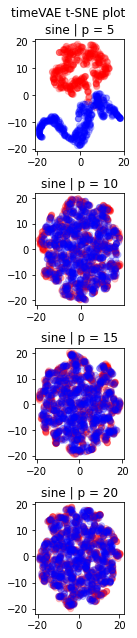

In [135]:
percs = [5,10,15,20]
datasets = ['sine']

figsize = ( len(datasets) * 2, 1 + len(percs) * 2)   # width by height
fig, axs = plt.subplots(len(percs), len(datasets), figsize=figsize)

for i, dataset in enumerate(datasets): 
  for j, perc in enumerate(percs):
    orig_data = get_data(f'/content/timeVAE-gen-eval/timeVAE/datasets/sine_subsampled_train_perc_{perc}.npz')
    gen_data = get_data(f'/content/timeVAE-gen-eval/timeVAE/outputs/timeVAE_gen_samples_sine_perc_{perc}.npz')
  #         print("orig, gen shapes: ", dataset, perc, orig_data.shape, gen_data.shape)

    if gen_data is None: continue
    
    N, T, D = orig_data.shape
    scaled_orig_data, scaled_gen_data = scale_data(orig_data, gen_data, scale_gen_data = True) 
    
    
    scaled_orig_2d, scaled_gen_2d = avg_over_feat_dim(scaled_orig_data, scaled_gen_data) 
    final_orig, final_gen = shuffle_and_subsample(scaled_orig_2d, scaled_gen_2d)        
    
    if final_orig.shape[0] != final_gen.shape[0]:
        final_orig = final_orig[:final_gen.shape[0]]
    
    N, T = final_orig.shape
    final_tsne_input = np.concatenate((final_orig, final_gen), axis = 0)        
  #         print('final_tsne_input shape: ', final_tsne_input.shape)

    # TSNE analysis
    tsne = TSNE(n_components = 2, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(final_tsne_input)

    colors = ["red" for i in range(N)] + ["blue" for i in range(N)] 

    axs[j].scatter(tsne_results[:N,0], tsne_results[:N,1], 
                c = colors[:N], alpha = 0.2)
    axs[j].scatter(tsne_results[N:,0], tsne_results[N:,1], 
                c = colors[N:], alpha = 0.2)
    
flat_labels = [(xl, yl) for xl in percs for yl in datasets]

for i, ax in enumerate(axs.flat):
    perc, dataset = flat_labels[i]
    ax.set_title(f'{dataset} | p = {perc}')

# fig.legend()
model = "timeVAE"
fig.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle(f'{model} t-SNE plot')
plt.savefig(f"{model}_tsne_results.png", dpi=300)  
plt.show()

# HIDDEN DATA CLASSIFIER

In [157]:
def Predictive_Classifier(perc):
  def get_data(input_file):
    loaded = np.load(input_file)
    return loaded['data']
  def create_classification_data():
    a = get_data(f"/content/timeVAE-gen-eval/timeVAE/datasets/sine_subsampled_train_perc_{perc}.npz")
    b = get_data(f"/content/timeVAE-gen-eval/timeVAE/outputs/timeVAE_gen_samples_sine_perc_{perc}.npz")
    size = 100*perc
    test_size = int(0.2*size)
    # print(test_size)
    a,b = scale_data(a,b)
    a,b = avg_over_feat_dim(a,b)
    y_a = np.zeros(size)
    y_b = np.ones(size)
    a,y_a = shuffle(a,y_a,random_state=0)
    a_held_out = a[:test_size]
    y_a_held_out = y_a[:test_size]
    a = a[test_size:]
    y_a = y_a[test_size:]
    X_train = np.concatenate((a,b), axis=0)
    y_train = np.concatenate((y_a,y_b), axis=0)
    X_train,y_train = shuffle(X_train,y_train,random_state = 0)
    X_test = a_held_out
    y_test = y_a_held_out
    return X_train, X_test, y_train, y_test
  def train_classifier():
    X_train, X_test, y_train, y_test = create_classification_data()
    # print(y_test, y_test.shape)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_train_pred = [int(y_pred>0.5) for y_pred in clf.predict(X_train)]
    y_test_pred = [int(y_pred>0.5) for y_pred in clf.predict(X_test)]
    print(f"ACCURACY ON TRAIN SET FOR DATA {perc}%: ", accuracy_score(y_train, y_train_pred))
    print(f"ACCURACY ON TEST SET FOR DATA {perc}%: ", accuracy_score(y_test, y_test_pred))

  train_classifier()

In [158]:
percs = [5,10,15,20]

for perc in percs:
  Predictive_Classifier(perc)

ACCURACY ON TRAIN SET FOR DATA 5%:  0.9222222222222223
ACCURACY ON TEST SET FOR DATA 5%:  0.88
ACCURACY ON TRAIN SET FOR DATA 10%:  0.6016666666666667
ACCURACY ON TEST SET FOR DATA 10%:  0.18
ACCURACY ON TRAIN SET FOR DATA 15%:  0.5851851851851851
ACCURACY ON TEST SET FOR DATA 15%:  0.13
ACCURACY ON TRAIN SET FOR DATA 20%:  0.5777777777777777
ACCURACY ON TEST SET FOR DATA 20%:  0.125
